# **A brief analysis of COVID-19's impact on India's AQI and Time Series Forecasting with SARIMA**

The air quality index (AQI) is an index for reporting air quality on a daily basis. A low AQI indicates good air quality and low levels of pollution while a higher AQI suggests increased concentrations of pollutants in the air which is extremely detrimental to human health.

The air quality index is composed of 8 pollutants ((PM10, PM2.5, NO2, SO2, CO, O3, NH3, and Pb)

AQI scores and categories:
Good (0–50)
Satisfactory (51–100)
Moderately polluted (101–200)
Poor (201–300)
Very poor (301–400)
Severe (401–500)

In this notebook, we will be using the day-wise AQI dataset which contains information regarding the daily level of pollutants and AQI in around 26 Indian cities from 2015-2020.

Our notebook has two major parts:
1. Finding the most polluted cities in recent years and analysing the levels of pollutants here. Understanding the impact of COVID-19 induced lockdowns on Air Quality in some of the major cities : analysing which cities underwent the most drastic improvement in Air Quality and which cities showed a spike in AQI levels inspite of a stringent lockdown

2. We do a time-series analysis of the data and and fit a SARIMA model with computed orders to forecast India's AQI in 2021.

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined in the requirements.in file
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [5]:
#importing day-wise data of cities
cities = pd.read_csv('../data/city_day.csv')

#visualizing the top rows of the dataset
cities.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [6]:
#getting information about the columns in our dataset
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


To be able to construct time plots, we need to first convert the Date column into a DateTime format.

In [7]:
print(cities.shape)

#converting column Date into DateTime format
cities['Date'] = pd.to_datetime(cities['Date'])

(29531, 16)


# Part 2 : Time Series Analysis and Forecasting:

In [9]:
import warnings
warnings.filterwarnings('ignore')

# importing day-wise data of cities

df= pd.read_csv('../data/city_day.csv')

df['Date'] = pd.to_datetime(df['Date'])

#visualizing the top rows of the dataset
df.tail(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory
29530,Visakhapatnam,2020-07-01,15.00,66.00,0.40,26.85,14.05,5.20,0.59,2.10,17.05,NaN,NaN,NaN,50.0,Good


We pivot the values from the 'City' column, so that we can have a comparitive view of the value of every city's AQI through every day.

Then we resample them to find the mean of every month, so now our dataset contains month-wise data.

In [10]:
cities_all = df.pivot_table(values='AQI', index=['Date'], columns='City')
cities_all=cities_all.add_suffix('_AQI')
cities=cities_all.resample(rule='MS').mean()
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Jorapokhar_AQI,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,350.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-01,520.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-01,418.571429,NaN,NaN,NaN,130.545455,NaN,NaN,NaN,363.800000,NaN,...,NaN,NaN,NaN,264.272727,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-01,308.640000,NaN,NaN,NaN,113.733333,NaN,NaN,NaN,175.862069,NaN,...,NaN,NaN,NaN,118.586207,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01,263.466667,NaN,NaN,NaN,102.774194,NaN,NaN,NaN,176.129032,NaN,...,NaN,NaN,NaN,137.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#form a new column containing India's AQI for every month by taking the average of all cities for that month
cities['India_AQI']=cities.mean(axis=1)
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI,India_AQI
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,350.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,346.311828
2015-02-01,520.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424.284286
2015-03-01,418.571429,NaN,NaN,NaN,130.545455,NaN,NaN,NaN,363.800000,NaN,...,NaN,NaN,264.272727,NaN,NaN,NaN,NaN,NaN,NaN,258.875688
2015-04-01,308.640000,NaN,NaN,NaN,113.733333,NaN,NaN,NaN,175.862069,NaN,...,NaN,NaN,118.586207,NaN,NaN,NaN,NaN,NaN,NaN,193.815995
2015-05-01,263.466667,NaN,NaN,NaN,102.774194,NaN,NaN,NaN,176.129032,NaN,...,NaN,NaN,137.000000,NaN,NaN,NaN,NaN,NaN,NaN,193.556272


<AxesSubplot:xlabel='Date'>

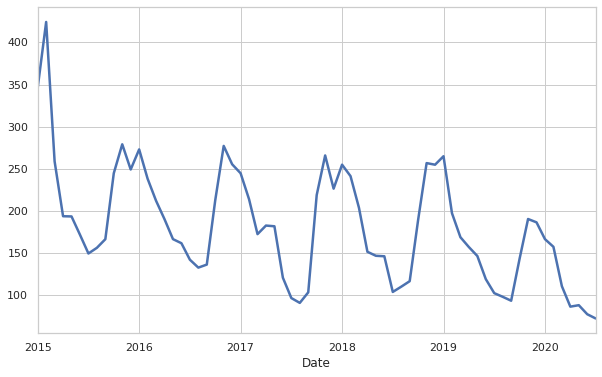

In [14]:
cities.reset_index()

sns.set_theme(style='whitegrid')

#plot India's AQI
cities['India_AQI'].plot(kind='line',grid=True,figsize=(10, 6), linewidth=2.5)

From the plot above, we can visually see that there is a slight downward trend and a seasonality present. However, we will decompose the plot into trend, seasonality and residuals to get a clearer picture.

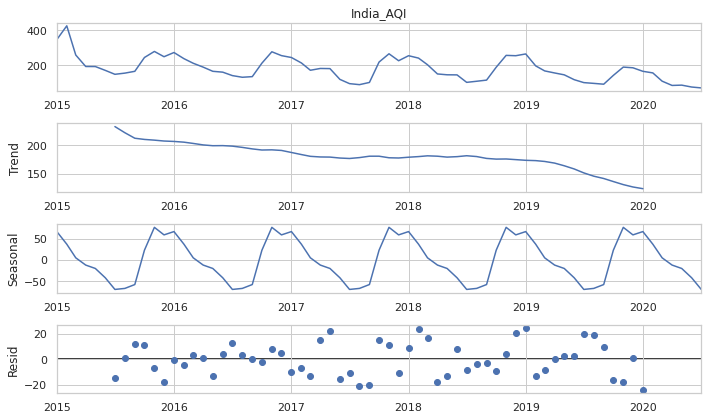

In [15]:
plt.rcParams['figure.figsize'] = (10, 6);
cities['India_AQI']=cities.mean(axis=1)
fig = seasonal_decompose(cities['India_AQI'], model='additive').plot()

We can see a clear seasonality and trend present here. The AQI decreases towards mid-year before rising again.

### Augmented Dicky Fuller Test:

We'll perform the ADF for determining stationarity of the time series.

In [16]:
dftest = adfuller(cities['India_AQI'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                 -0.114224
p-value                         0.948003
#Lags Used                     10.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64

The p-value is 0.94, which means that this time series is not stationary.
We perform a first order differencing to remove the trend and then perform the ADF test again.

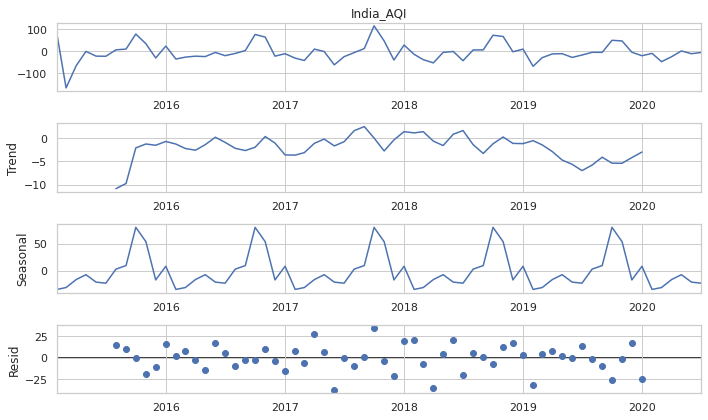

In [17]:
diff = cities['India_AQI'].diff(periods=1)
diff.dropna(inplace=True)
fig = seasonal_decompose(diff, model='additive').plot()

In [18]:
dftest = adfuller(diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -8.385232e+00
p-value                        2.448599e-13
#Lags Used                     9.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64

From the p-value and the Test Statistic, we can conclude that with one differencing, the time series becomes stationary. Therefore, d=1.

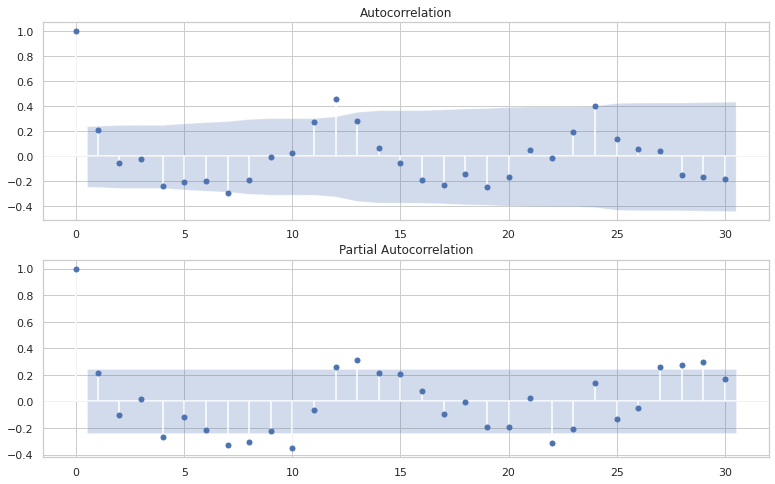

In [19]:
fig, ax = plt.subplots(2,figsize=(13, 8))
ax[0] = plot_acf(diff, lags=30, ax=ax[0])
ax[1] = plot_pacf(diff,lags=30, ax=ax[1])

We can use auto-arima to determine the parameters of the SARIMA model.

In [20]:
#import pmdarima
from pmdarima import auto_arima;

In [21]:
auto_arima(y=cities['India_AQI'],start_p=1,start_P=1,start_q=1,start_Q=1,seasonal=True,m=12, 
           stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   67
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -316.908
Date:                              Sat, 28 Aug 2021   AIC                            643.816
Time:                                      07:50:12   BIC                            654.765
Sample:                                           0   HQIC                           648.143
                                               - 67                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0189      0.059      0.320      0.749      -0.097       0.135
ma.L2         -0.8363      0.069    -12.077      0.000      -0.972      -0.701
ar.S.L12       0.9444      0.062     15.221      0.000       0.823       1.066
ma.S.L12      -0.5623      0.229     -2.458      0.014      -1.011      -0.114
sigma2       694.3699    142.983      4.856      0.000     414.129     974.611
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 2.99
Prob(Q):                              0.33   Prob(JB):                         0.22
Heteroskedasticity (H):               0.38   Skew:                            -0.52
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
#dividing into train and test:
train_data = cities['India_AQI'][:'2018-12']
test_data = cities['India_AQI'][:'2019-12']

#Building the model:
model=SARIMAX(train_data,order=(0,1,2),seasonal_order=(1,0,1,12), trend='n')
results=model.fit()

#printing summry of model reults
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            India_AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -229.813
Date:                              Sat, 28 Aug 2021   AIC                            469.625
Time:                                      07:50:13   BIC                            478.876
Sample:                                  01-01-2015   HQIC                           473.106
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0645      0.595      0.108      0.914      -1.101       1.230
ma.L2         -0.9324      0.585     -1.595      0.111      -2.078       0.213
ar.S.L12       0.9183      0.097      9.440      0.000       0.728       1.109
ma.S.L12      -0.4473      0.301     -1.485      0.138      -1.038       0.143
sigma2       767.0660    441.341      1.738      0.082     -97.946    1632.078
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.63   Prob(JB):                         0.16
Heteroskedasticity (H):               0.24   Skew:                            -0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

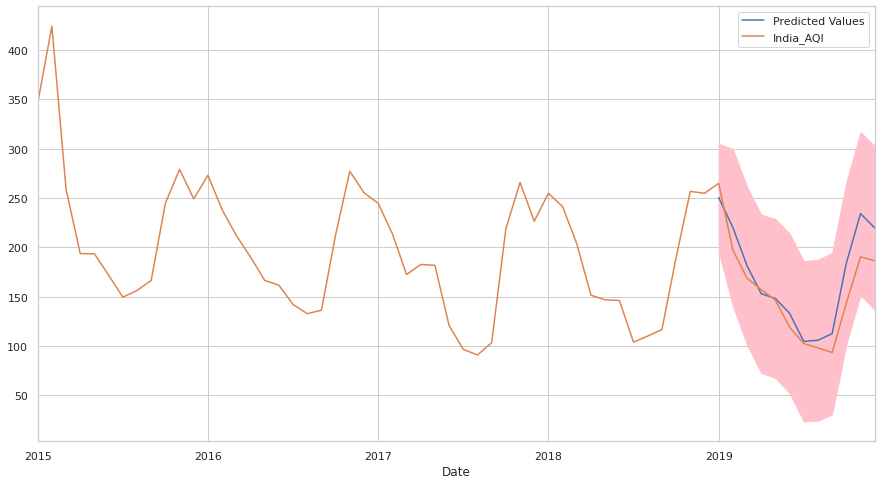

In [23]:
fig, ax= plt.subplots(figsize=(15,8))

#predict the next 12 months values to compare with the test dataset
forecasts = results.get_forecast(steps=12, dynamic=True)

#find the confidence intervals
confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

#plot the forecasted mean data for the next 12 months and the confidence interval
forecasts.predicted_mean.plot(legend=True, ax=ax, label ='Predicted Values')
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')

#plotting the actual value from test data
test_data.plot(legend=True, ax=ax)

In [24]:
from sklearn.metrics import mean_squared_error

test= cities['India_AQI']['2019-01':'2019-12']
RMSE=np.sqrt(mean_squared_error(forecasts.predicted_mean,test))
print('RMSE = ',RMSE)

RMSE =  22.754908120784584


We see that the model has an RMSE of 22.75 on the test data set. Now, we can use this model to predict values into the future.

We'll be forecastig AQI values for 2021. However, 2020 yielded unexpected AQI values owing to the lockdown imposed due to COVID-19, as we saw earlier. So our prediction might have a wider margin of error to be considered.

<AxesSubplot:xlabel='Date'>

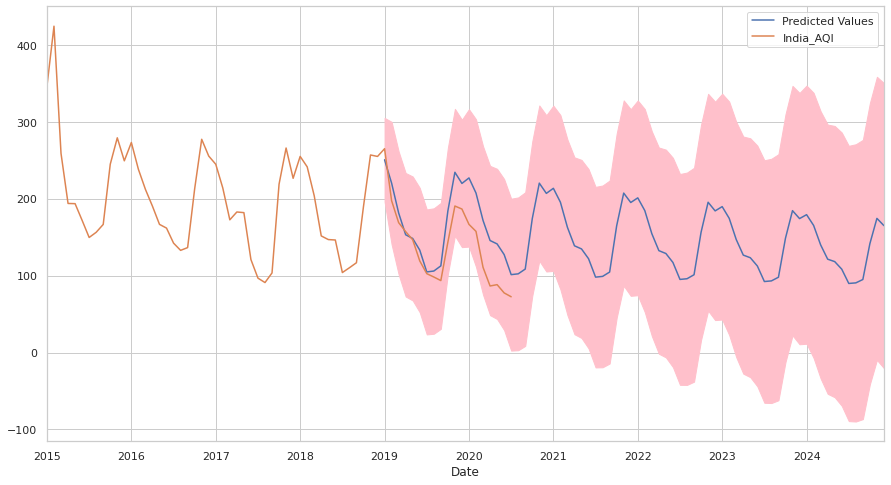

In [25]:
fig, ax= plt.subplots(figsize=(15,8))

forecasts = results.get_forecast(steps=72, dynamic=True)

confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

#plot the forecasted data
forecasts.predicted_mean.plot(legend=True, ax=ax, label ='Predicted Values')

#plot the confidence interval as the shaded area
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')

#Plot India's AQI Data
cities['India_AQI'].plot(legend=True, ax=ax)

In [26]:
forecasts.predicted_mean

2019-01-01    250.590756
2019-02-01    220.302880
2019-03-01    181.542186
2019-04-01    153.112055
2019-05-01    148.287832
                 ...    
2024-08-01     90.560046
2024-09-01     94.948061
2024-10-01    141.564479
2024-11-01    174.424661
2024-12-01    164.954049
Freq: MS, Name: predicted_mean, Length: 72, dtype: float64